In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K
from keras import regularizers

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [3]:
# the data, split between train and test sets
dfAll = pd.read_pickle("DataStudyCollection/df_blobs_area.pkl")

lst = dfAll.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]
print(train_ids, test_ids)
print(len(train_ids), ":", len(test_ids))
print(len(train_ids) / len(lst), ":", len(test_ids)/ len(lst))

df_train = dfAll[dfAll.userID.isin(train_ids)]
df_test = dfAll[dfAll.userID.isin(test_ids) & (dfAll.Version == "Normal")]

df_train2 = df_train[['Blobs', 'InputMethod']].copy()
df_test2 = df_test[['Blobs', 'InputMethod']].copy()

[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]
13 : 5
0.7222222222222222 : 0.2777777777777778


In [4]:
len(dfAll)

618012

In [5]:
x_train = np.vstack(df_train2.Blobs)
x_test = np.vstack(df_test2.Blobs)
y_train = df_train2.InputMethod.values
y_test = df_test2.InputMethod.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [6]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = utils.to_categorical(df_train2.InputMethod, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: 0')

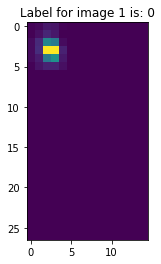

In [7]:
i = 1
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [8]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.2

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [ ]:
tf.get_default_graph()
########## HYPER PARAMETERS

batch_size = 2000
epochs = 100000
optimizer = tf.keras.optimizers.Adam(lr=0.001)

l1v = 0.005
l2v = 0.015
#optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1), 
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v)))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v)))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v)))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v)))
model.add(tf.keras.layers.BatchNormalization(axis=-1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format='channels_last'))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(140, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(70, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1v,l2v), use_bias=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD
config += "batchsize: " + str(batch_size) + "\n\n" + "epochs: " + str(epochs) + "\n\n"

# Print summary
current_name = "CNN"
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/srv/share/tensorboardfiles/" + current_name + readable_timestamp
print(current_name + readable_timestamp)

model.summary()
logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0,
                            write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/" + current_name + readable_timestamp + '-{epoch:03d}.h5',
                         monitor='val_acc', verbose=1,
                         save_best_only=True, save_weights_only=False,
                         mode='auto', period=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=140, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)
# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer, learning_rate_reduction])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
CNN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 15, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 15, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 15, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 8, 64)         0         
_________________________________________________________________
dropout_1 (Dropou

In [ ]:
model.save("./ModelSnapshots/" + current_name + "_DONE.h5")

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()